<a href="https://colab.research.google.com/github/faizanahemad/eva/blob/master/assignment-6/Assignment_6B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Results:**

96k params, 50 epochs, One Cycle LR

```
Train
Score =  [0.5939844024848938, 0.825160000076294]
Balanced Accuracy = 82.30%, Accuracy = 82.30%

Test
Score =  [0.5828060176849366, 0.8305000000953674]
Balanced Accuracy = 80.47%, Accuracy = 80.47%
```

# Imports

In [1]:

!pip install --upgrade --upgrade-strategy only-if-needed https://github.com/faizanahemad/data-science-utils/tarball/master > /dev/null
!pip install git+https://www.github.com/keras-team/keras-contrib.git > /dev/null
!pip install keract > /dev/null

  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-i6i13iiw


In [2]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, DepthwiseConv2D, Conv2D, SeparableConv2D
from keras.layers import Input, concatenate
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import GlobalAveragePooling2D
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Nadam, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.regularizers import l2
%config InlineBackend.figure_format='retina'
from keras_contrib.callbacks import CyclicLR
from keras.models import Model

from data_science_utils.vision.keras import *

Using TensorFlow backend.


170500096/170498071 [==============================] - 11s 0us/step


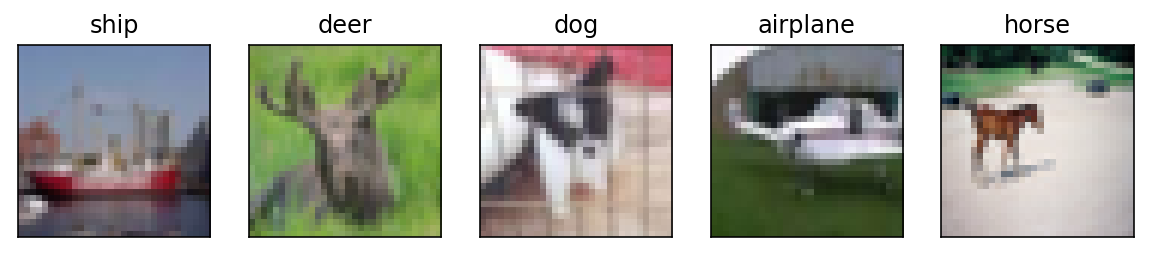

In [3]:
X_train, Y_train, X_test, Y_test = get_cifar10_data()
classes = get_cifar10_labels()
show_examples(X_train[10:15], Y_train[10:15], classes)

# Helper Functions

In [0]:
def conv_layer(inputs, n_kernels=32, kernel_size=(3,3), dropout=0.1,dilation_rate=1, padding='valid'):
  out = Conv2D(n_kernels,
                kernel_size=kernel_size,
                strides=1,
                padding=padding,
                kernel_regularizer=l2(1e-4),
                dilation_rate=dilation_rate)(inputs)
  out = BatchNormalization()(out)
  out = Activation("relu")(out)
  out = Dropout(dropout)(out)
  return out

def depthwise_conv_layer(inputs, n_kernels=32, kernel_size=(3,3),dropout=0.1,dilation_rate=1, padding='valid', depth_multiplier=1,):
  out = SeparableConv2D(n_kernels,
                kernel_size=kernel_size,
                strides=1,
                padding=padding,
                kernel_regularizer=l2(1e-4),
                dilation_rate=dilation_rate,
                depth_multiplier=depth_multiplier,)(inputs)
  out = BatchNormalization()(out)
  out = Activation("relu")(out)
  out = Dropout(dropout)(out)
  return out

def separable_layer(inputs, n_kernels=32, kernel_size=(3,3),dropout=0.1,dilation_rate=1, padding='same'):
  # We use kernel_size[0]x1 and then 1xkernel_size[1] conv
  
  out = Conv2D(n_kernels,
                kernel_size=(kernel_size[0],1),
                padding=padding,
                kernel_regularizer=l2(1e-4),
                dilation_rate=dilation_rate,
                strides=dilation_rate, # to achive right dilation with separable we need to use strides.
                )(inputs)
  out = Conv2D(n_kernels,
                kernel_size=(1,kernel_size[1]),
                padding=padding,
                kernel_regularizer=l2(1e-4),
                dilation_rate=dilation_rate,
                strides=dilation_rate, # to achive right dilation with separable we need to use strides.
                )(out)
  out = BatchNormalization()(out)
  out = Activation("relu")(out)
  out = Dropout(dropout)(out)
  return out
  


def transition_layer(inputs, n_kernels=32,dropout=0):
  out = conv_layer(inputs, n_kernels, kernel_size=(1,1),dropout=dropout, padding='same')
  return out

def output_layer(inputs, n_classes, kernel_size):
  out = Conv2D(n_classes,
                kernel_size=kernel_size,
                strides=1,
                padding='valid',
                kernel_regularizer=l2(1e-4),
                dilation_rate=1)(inputs)
  out = GlobalAveragePooling2D()(out)
  # print(K.int_shape(out))
  # out = Flatten()(out)
  out = Activation("softmax")(out)
  return out

def grouped_layer(inputs, group_configs, out_channels):
  groups = []
  for group_config in group_configs:
    out1 = inputs
    for layer_config in group_config:
      out1 = conv_layer(out1, **layer_config)
    groups.append(out1)
  y = concatenate(groups)
  y = transition_layer(y, out_channels)
  return y

# Functional API model

- Our Approach will be to define Residual network
- We will build 6 modular functions so that we can reuse.
- Each function makes one type of convolution, adding BatchNorm, Activation and Dropout as well.
- Proposed arch
  - **conv_layer**(inputs, n_kernels=32, kernel_size=(3,3),dropout=0.1,dilation_rate=1, padding='valid') - 30
  - **conv_layer**(inputs, n_kernels=64, kernel_size=(3,3),dropout=0.1,dilation_rate=1, padding='same') - 30
  - **separable_layer**(inputs, n_kernels=64, kernel_size=(3,3),dropout=0.1,dilation_rate=1, padding='valid') - 28
  - **depthwise_conv_layer**(inputs, n_kernels=128, kernel_size=(3,3),dropout=0.1,dilation_rate=1, padding='valid') - 26
  - **MaxPool**
  - **transition_layer**(inputs, n_kernels=32,dropout=0.1) - 13
  - **grouped_layer**(inputs,group_configs,out_channels) - 13
  - **grouped_layer_v2** - 13
  - **MaxPool**(padding='same') - 7
  - **conv_layer**(inputs, n_kernels=64, kernel_size=(3,3),dropout=0.1,dilation_rate=1, padding='valid') - 5
  - **output_layer**(inputs, n_classes, kernel_size=(5,5))
  

In [0]:
inputs = Input(shape=(32,32,3))
x = conv_layer(inputs,n_kernels=32,kernel_size=(3,3),padding='valid') # rf = 3
x = conv_layer(x,n_kernels=32,kernel_size=(3,3),padding='same') # rf = 5
x = separable_layer(x, n_kernels=64,kernel_size=(3,3),padding='valid') # rf = 7
x = depthwise_conv_layer(x, n_kernels=128,kernel_size=(3,3),padding='valid') # rf = 9
x = MaxPooling2D(pool_size=(2, 2))(x)
x = transition_layer(x, n_kernels=32,dropout=0)
x = grouped_layer(x, group_configs=[[dict(n_kernels=16, kernel_size=(3,3), dropout=0.1,dilation_rate=1, padding='same')],
                                    [dict(n_kernels=16, kernel_size=(5,5), dropout=0.1,dilation_rate=1, padding='same')]],
                 out_channels = 32)

x = grouped_layer(x, group_configs=[[dict(n_kernels=16, kernel_size=(3,3), dropout=0.1,dilation_rate=1, padding='same')],
                                    [dict(n_kernels=16, kernel_size=(3,3), dropout=0.1,dilation_rate=2, padding='same')]],
                 out_channels = 32)

# Each inner array represents one pipeline/group in the groups of the grouped_layer

x = MaxPooling2D(pool_size=(2, 2),padding='same')(x)
x = conv_layer(x, n_kernels=64,kernel_size=(3,3),padding='valid') # rf = 3
x = transition_layer(x, n_kernels=32,dropout=0)

output = output_layer(x, n_classes=10, kernel_size=(3,3))

model = Model(inputs=inputs, outputs=output)

optimizer = Adam(lr=0.001,)


model.compile(loss='categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

In [14]:
model.count_params()

96042

In [15]:
X_train, Y_train, X_test, Y_test = get_cifar10_data(preprocess=False)
datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,
                             rotation_range=10,shear_range=0.02,
                             height_shift_range=0.1,width_shift_range=0.1,zoom_range=0.2,horizontal_flip=True)

datagen_validation = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,)
datagen.fit(X_train)
datagen_validation.fit(X_train)
train_iterator = datagen.flow(X_train, Y_train, batch_size=256,shuffle=True)
test_iterator = datagen_validation.flow(X_test, Y_test, batch_size=1024,shuffle=True),
validation_iterator = datagen.flow(X_test, Y_test, batch_size=1024,shuffle=True)

checkpoint = ModelCheckpoint("model.hdf5", monitor='acc', verbose=0, save_best_only=True, mode='max')
clr = CyclicLR(base_lr=0.0001,max_lr=0.02,step_size=500, mode='triangular2')
callbacks_list = [checkpoint,clr]
train_history = model.fit_generator(train_iterator,
                    steps_per_epoch=len(train_iterator), 
                    validation_data = validation_iterator, 
                    validation_steps = len(validation_iterator),
                    epochs=50, verbose=1,
                    callbacks=callbacks_list,)

print("Layer Names: ",[layer.name for layer in model.layers[0:]])

model.load_weights("model.hdf5")


iterator = datagen.flow(X_train, Y_train, batch_size=512, shuffle=False)
score = model.evaluate_generator(iterator,steps=len(iterator))
iterator = datagen.flow(X_train, Y_train, batch_size=1024, shuffle=False)
predictions = model.predict_generator(iterator,steps=len(iterator))
_ = inspect_predictions(score, predictions,Y_train, classes=get_cifar10_labels(),print_results=True, plot_results=False)


iterator = datagen_validation.flow(X_test, Y_test, batch_size=1024, shuffle=False)
score = model.evaluate_generator(iterator,steps=len(iterator))
iterator = datagen.flow(X_test, Y_test, batch_size=1024, shuffle=False)
predictions = model.predict_generator(iterator,steps=len(iterator))
_ = inspect_predictions(score, predictions,Y_test, classes=get_cifar10_labels(),print_results=True, plot_results=False)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
196/196 [==============================] - 59s 299ms/step - loss: 1.7258 - acc: 0.3778 - val_loss: 6.2345 - val_acc: 0.2052
Epoch 2/50
196/196 [==============================] - 46s 232ms/step - loss: 1.3485 - acc: 0.5382 - val_loss: 3.5559 - val_acc: 0.3344
Epoch 3/50
196/196 [==============================] - 53s 272ms/step - loss: 1.2339 - acc: 0.5999 - val_loss: 3.3817 - val_acc: 0.3815
Epoch 4/50
196/196 [==============================] - 53s 271ms/step - loss: 1.1170 - acc: 0.6535 - val_loss: 1.3069 - val_acc: 0.5949
Epoch 5/50
196/196 [==============================] - 53s 270ms/step - loss: 0.9854 - acc: 0.6994 - val_loss: 1.1053 - val_acc: 0.6582
Epoch 6/50
196/196 [==============================] - 53s 271ms/step - loss: 0.9078 - acc: 0.7243 - val_loss: 1.1295 - val_acc: 0.6443
Epoch 7/50
196/196 [==============================] - 53s 271ms/step - loss: 0.9580 - acc: 0.7065 - val_loss: 1.1632 - val_acc: 0.6329
Epoch 8

# Questions

- Can I use conv_layer with 1x3 and 3x1 for separable. i.e. will doing batchnorm and dropout after just the 1st 1x3 make sense for separable layer

- How to make receptive field bigger than input image?